### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

Программа урока:

1. Теоретическая часть:
    - Проблема интерпретируемости моделей
    - Примеры, когда это важно
    - Обзор методов

2. Практическая часть:
    - Feature importance, доступный в самих моделях
    - Permutation Importance
    - SHAP

На уроке будет затронут важный для любого бизнеса, применяющего машинное обучение при решении задач, аспект - интерпретируемость моделей. Т.е важно не только умение обучать модели, которые делают качественные прогнозы, но и умение объяснить эти прогнозы. Когда мы не просто понимаем, что пользователь склонен совершить некоторое действие (например, уйти в отток), но и можем выявить факторы, влияющие на это, что позволяет скорректировать стратегию взаимодействия с пользователями (как пример). Такая модель может быть полезна не только своими прогнозами, но и инсайтами, которые скрыты в данных. 

### Обзор методов

- важные признаки в модели (feature importance)
- влияние каждого отдельного признака на конкретный прогноз 
- влияние каждого признака на большое количество возможных прогнозов (топ k наблюдений, например)

In [40]:
!pip install shap

### 1. Feature importance признаков

Пример с линейной моделью

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [41]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [42]:
path ='/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection7/'

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv(path + "kc_house_data.csv")
print(df.shape)
df.head(3)

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [44]:
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [45]:
features = ["bedrooms", "sqft_living", "sqft_lot", "yr_built"]
target = "price"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

Соберем пайплайн

In [46]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [47]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [48]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bedrooms',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('yr_built',
                                                 Pipeline(memory=None,
                          

Посчитаем MAE и коэффициент детерминации (R2)

In [49]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.49573861936, 0.5365765901167386)

mae малоинформативен, но вот r2 - очень понятен.

На случай, если кто забыл:

![r2](r2.png "R2 score")

Интерпретация:

1. принимает значения от -1 до 1. Чем ближе к 1, тем лучше модель объясняет данные (соответствует модели данных)
2. значение 1 означает функциональную зависимость y от X
3. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше

источник на вики - https://ru.wikipedia.org/wiki/Коэффициент_детерминации

Наконец, давайте посмотрим на "важность" признаков (в линейной регрессии это просто веса (коэффициенты) при предикторах (признаках)

Сразу же возьмем абсолютные значения коэффициентов

In [50]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.head()

,coefficient
bedrooms,-55705.016661
yr_built,-71039.334129
sqft_living,316113.766523
sqft_lot,-14820.959494


Как это можно интерпретировать:

1. sqft_living имеет наибольшую важность и положителен (чем выше жилая площадь, тем выше стоимость)
2. остальные признаки уже идут с отрицательным весом
3. вторым по важности признаком является год постройки (yr_built)

### Перейдем к "деревянным" моделям

In [51]:
import xgboost as xgb

In [52]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

[15:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bedrooms',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('yr_built',
                                                 Pipeline(memory=None,
                          

In [53]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(147512.7954061806, 0.6125861289964616)

In [54]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

,coefficient
bedrooms,0.037282
yr_built,0.131452
sqft_living,0.750951
sqft_lot,0.080315


Как можно считать feature_importance в моделях на базе деревьев решений

![xgboost](xgboost_tree.png "Xgboost tree")

Ссылка (рекомендую поизучать на досуге) - https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Существует несколько вариантов как для признака в деревьях решений посчитать важность

1. Gain - показывает относительный вклад каждой фичи в модель. 
Алгоритм простой - идем по каждому дереву, смотрим в каждом узле дерева по какому признаку происходит разбиение узла и насколько снижаетcя неопределенность (gini impurity, information gain). Далее для каждого признака суммируется её вклад (по всем деревьям)

2. Frequency - показывает, как часто конкретный признак встречается в узлах дерева, то есть считается суммарное количество разбиений дерева на узлы для каждого признака в каждом дереве.

<b>Вопрос:</b>
Какие еще вы знаете модели со "встроенной" возможностью определять важность признаков?

Ваш ответ:

#### Краткий вывод:

Подходы, основанные на feature_importance, очень удобны, т.к по факту мы получаем готовый функционал и можем хоть какую-то интерпретацию давать без каких-либо внешних инструментов.

Однако проблема такого подхода заключается в том, что непонятно, как именно данная фича влияет на итоговый прогноз. 

Пример: жилая площадь важна для прогноза стоимости жилья, но как именно это может быть связано с другими признаками? Это будет в пункте 3, а сейчас давайте рассмотрим еще один (из множества) способ расчета "важности" признаков

### 2. Permutation importance

Алгоритм очень простой:

- обучаем модель на тренировочном наборе данных
- проверяем качество на валидации
- для валидационного набора данных перемешиваем один из признаков
- снова проверяем качество на нем же

Признак считается «важным», если качество модели падает при его перемешивании.

Очень удобно, что в sklearn есть возможность из коробки такое делать

In [55]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

Пример как это может выглядеть на выходе

In [56]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

yr_built 1.441 +/- 0.042
sqft_lot 0.095 +/- 0.010
sqft_living 0.048 +/- 0.004
bedrooms 0.012 +/- 0.002


Интересно, что результаты немного другие, нежели при использовании "встроенного" feature_importances_)

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

### SHAP

ссылка на проект - https://github.com/slundberg/shap

Wiki - https://en.wikipedia.org/wiki/Shapley_value

Значения Шэпли пришли к нам из теории игр.

Пример - группа людей (далее - коалиция) играет в игру. 

Необходимо распределить призовой фонд между ними в зависимости от их вклада.

Уточнения (допущения):

- игроки с равным вкладом должны получить одинаковую награду
- если вклад игрока нулевой, то награда также нулевая
- если игрок провел несколько игр, то его награда - это сумма наград за каждую из игр

Немного математики (ссылка - https://en.wikipedia.org/wiki/Shapley_value)

![shap2](shap2.png "SHAP 1")

u - это выигрыш команды

n - количество игроков

S - коалиция (подмножество из n без игрока i)

А теперь попробуем "переложить" все это на вариант с задачей обучения с учителем

- игра - результат обучения с учителем (на основе заданного примера)
#- выигрыш – это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере
- вклады игроков в игру – влияние каждого значения признака на выигрыш, т.е. результат.

Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (каждого наблюдения) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи.

Расчет SHAP values очень тяжелый и затратный как по времени так и по ресурсам!

![ab_split](shap1.png "SHAP 1")

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. 

Он основан на Векторе Шепли - принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу (https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80). 

### ПЕРЕРЫВ до 20:55 (МСК)

### Игрушечный пример 

ссылка - https://arxiv.org/pdf/1802.03888.pdf

![shap4](shap4.png "SHAP 4")

На выходе для комбинации {Fever=Yes, Cough=Yes} хотим получить значимость признаков (т.е для конкретного наблюдения). 

Посчитаем выход модели для каждой возможной комбинации признаков:

![shap4](shap3.png "SHAP 3")

Теперь посчитаем SHAP для признака Fever для модели А (левое дерево).

Для этого посчитаем все необходимое для комбинаций признаков, которые не включают Fever:
![shap4](shap5.png "SHAP 5")

таких у нас 2:
![shap4](shap6.png "SHAP 6")

Подставляем значения в формулу и получаем SHAP для признака Fever:

![shap7](shap7.png "SHAP 7")

А теперь для признака Cough:

![shap8](shap8.png "SHAP 8")

Для модели B (дерево справа) получаем такое:

![shap9](shap9.png "SHAP 9")

Получаем значимость признаков на уровне одного примера с конкретными значениями признаков. 

* phi_0 - ожидаемый результат (для первой модели мы можем попасть в один из 4 листьев - ответ 20, для второй - 25)
* phi - ответ модели для конкретного наблюдения ({Fever=True, Cough=True}) - для первой модели 80, для второй - 90

### Пример (данные оттока с 5 занятия)

In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df.head(3)

NameError: name 'path' is not defined

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Exited'], random_state=0)

In [ ]:
model = xgboost.train(  {"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer( model)
shap_values = explainer.shap_values(X_train)

# покажем объяснение первого примера (берем matplotlib=True для обхода Javascript)
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [61]:
n=110
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[n,:], X_train.iloc[n,:])

In [62]:
shap_values[0,:]

array([ 0.00069391, -0.01944051, -0.00298425,  0.02925653,  0.00032652,
        0.02759313,  0.00084633], dtype=float32)

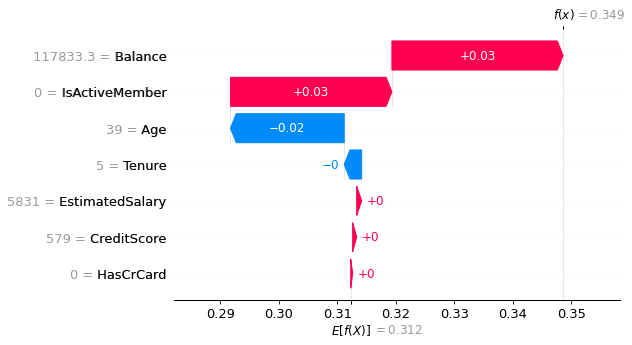

In [63]:
shap_values_all = explainer(X_train.iloc[:1000,:])

shap.initjs() # для работы в колаборатории 
shap.plots.waterfall(shap_values_all[0])

In [64]:
exp_sh=explainer.shap_interaction_values(X_train)

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, на сколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, на сколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

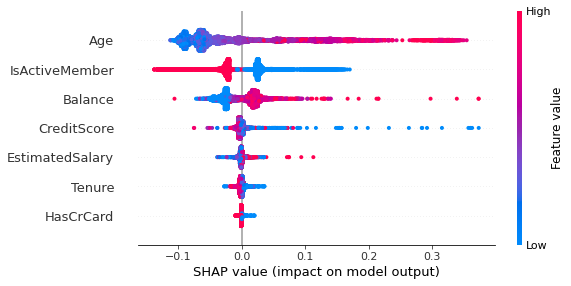

In [65]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем старше человек, тем выше вероятность ухода
- чем признак IsActiveMember выше, то вероятность ухода ниже
- чем выше баланс, тем выше вероятность ухода (?)

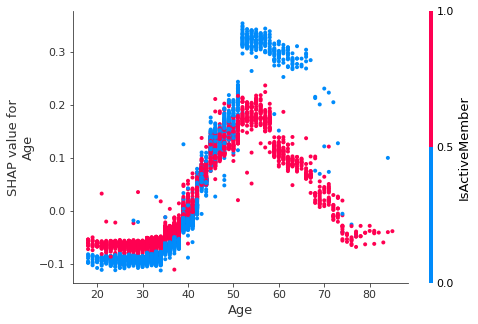

In [66]:
shap.dependence_plot("Age", shap_values, X_train)
#shap.dependence_plot("yr_built", shap_values, X_train)

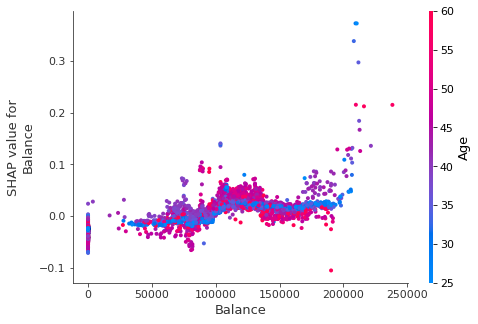

In [67]:
shap.dependence_plot("Balance", shap_values, X_train)

Можно даже просто взять средние значения SHAP для каждого признака (среднее значение величин SHAP по набору данных и отображает его в виде столбчатой ​​диаграммы.)

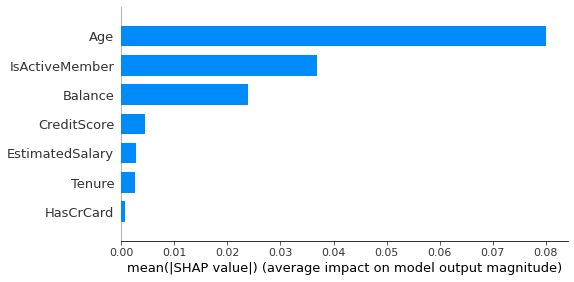

In [68]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

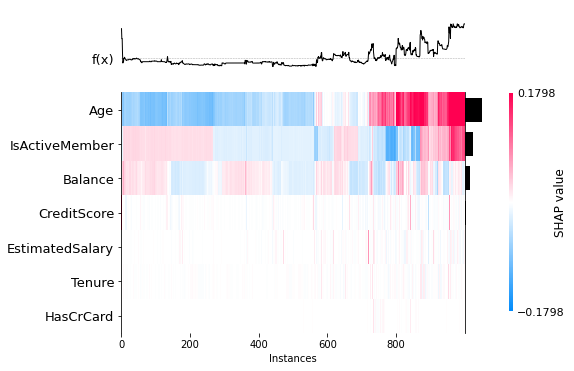

In [69]:
shap.initjs() # для работы в колаборатории 

shap.plots.heatmap(shap_values_all)

In [70]:
n = 40
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 

### Выбор гиперпараметров


Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)


Для подбора параметров воспользуемся реализацией алгоритма Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Алгоритм использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO). Метод основывается в байесовской оптимизации и гауссовских процессах.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [71]:
!pip install hyperopt --upgrad


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

ambiguous option: --upgrad (--upgrade, --upgrade-strategy?)


In [72]:
from functools import partial
#import xgboost as xgb
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

In [73]:
#разделим данные на train/test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

In [74]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(X_train, y_train)
valid_c = xgb.DMatrix(X_val, y_val)
test_c = xgb.DMatrix(X_test, y_test)

In [75]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [76]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [77]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective':'binary:logistic',
              'max_depth': hp.choice('max_depth', [2,3,4,5,6,7, 8, 10, 12, 15,50,70, 100,200]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
           
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [78]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [00:30<00:00,  1.66it/s, best loss: 0.16640020000000003]


In [79]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.4848242777281174,
 'colsample_bytree': 0.6447033933807078,
 'eta': 0.4238459729196984,
 'lambda': 0.178500186463113,
 'max_depth': 4,
 'min_child_weight': 39.82708784734517,
 'objective': 'binary:logistic',
 'subsample': 0.9980376390225719,
 'tree_method': 'hist'}

In [80]:
train_params = {'num_boost_round': 300,
                'maximize': False,
                'verbose_eval': False}

In [81]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train( params=best_params, dtrain=train_c, early_stopping_rounds=10,
                     evals=[(train_c, "train"), (valid_c, "valid")],
                     evals_result=progress, **train_params)

In [82]:
progress['train']

{'error': [0.169778,
  0.1712,
  0.178489,
  0.170667,
  0.168356,
  0.165867,
  0.164622,
  0.163556,
  0.163556,
  0.162844,
  0.161778]}

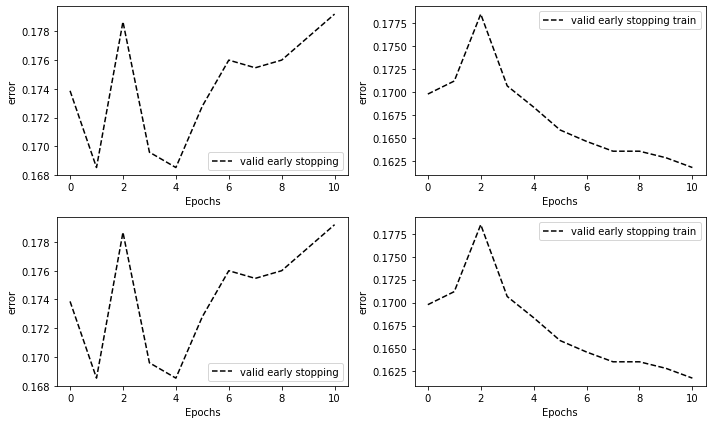

In [83]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)

plt.plot(progress['valid']['error'], label='valid early stopping', linestyle='dashed', color='black')

plt.xlabel('Epochs'); plt.ylabel('error'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)

plt.plot(progress['train']['error'], label='valid early stopping train', linestyle='dashed', color='black')

plt.xlabel('Epochs'); plt.ylabel('error'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)

plt.plot(progress['valid']['error'], label='valid early stopping', linestyle='dashed', color='black')


plt.xlabel('Epochs'); plt.ylabel('error'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)

plt.plot(progress['train']['error'], label='valid early stopping train', linestyle='dashed', color='black')


plt.xlabel('Epochs'); plt.ylabel('error'); plt.legend(); plt.tight_layout(); plt.show()

In [84]:
explainer_2 = shap.TreeExplainer(xgb_freq)
shap_values_2 = explainer_2.shap_values(X_train)

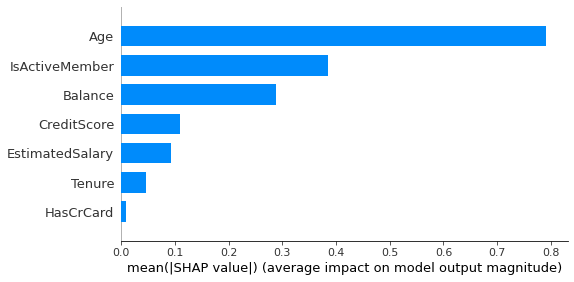

In [85]:
shap.summary_plot(shap_values_2, X_train, plot_type="bar")

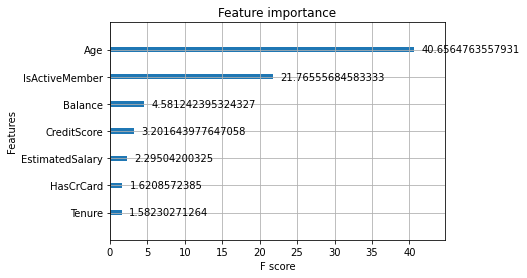

In [86]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[1]); plt.show()

In [87]:
n = 400
shap.initjs() 
shap.force_plot(explainer_2.expected_value, shap_values_2[:n,:], X_train.iloc[:n,:])